# Ungraded Lab: Mask R-CNN Image Segmentation Demo

In this lab, you will see how to use a [Mask R-CNN](https://arxiv.org/abs/1703.06870) model from Tensorflow Hub for object detection and instance segmentation. This means that aside from the bounding boxes, the model is also able to predict segmentation masks for each instance of a class in the image. You have already encountered most of the commands here when you worked with the Object Dection API and you will see how you can use it with instance segmentation models. Let's begin!

*Note: You should use a TPU runtime for this colab because of the processing requirements for this model. We have already enabled it for you but if you'll be using it in another colab, you can change the runtime from `Runtime --> Change runtime type` then select `TPU`.*

## Installation

As mentioned, you will be using the Tensorflow 2 [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection). You can do that by cloning the [Tensorflow Model Garden](https://github.com/tensorflow/models) and installing the object detection packages just like you did in Week 2.

In [1]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3699, done.
remote: Counting objects: 100% (3699/3699), done.
remote: Compressing objects: 100% (3089/3089), done.
remote: Total 3699 (delta 991), reused 1526 (delta 561), pack-reused 0
Receiving objects: 100% (3699/3699), 48.77 MiB | 19.39 MiB/s, done.
Resolving deltas: 100% (991/991), done.


In [2]:
# Compile the Object Detection API protocol buffers
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

In [3]:
%%writefile models/research/setup.py

import os
from setuptools import find_packages
from setuptools import setup

REQUIRED_PACKAGES = [
    'tf-models-official==2.7.0',
    'tensorflow_io'
]

setup(
    name='object_detection',
    version='0.1',
    install_requires=REQUIRED_PACKAGES,
    include_package_data=True,
    packages=(
        [p for p in find_packages() if p.startswith('object_detection')] +
        find_packages(where=os.path.join('.', 'slim'))),
    package_dir={
        'datasets': os.path.join('slim', 'datasets'),
        'nets': os.path.join('slim', 'nets'),
        'preprocessing': os.path.join('slim', 'preprocessing'),
        'deployment': os.path.join('slim', 'deployment'),
        'scripts': os.path.join('slim', 'scripts'),
    },
    description='Tensorflow Object Detection Library',
    python_requires='>3.6',
)

Writing models/research/setup.py


In [4]:
# Run the setup script you just wrote
!python -m pip install models/research

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./models/research
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-text to determi

## Import libraries

In [6]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from six import BytesIO
from PIL import Image
from six.moves.urllib.request import urlopen

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

tf.get_logger().setLevel('ERROR')

%matplotlib inline

## Utilities

For convenience, you will use a function to convert an image to a numpy array. You can pass in a relative path to an image (e.g. to a local directory) or a URL. You can see this in the `TEST_IMAGES` dictionary below. Some paths point to test images that come with the API package (e.g. `Beach`) while others are URLs that point to images online (e.g. `Street`).

In [5]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
        path: the file path to the image

    Returns:
        uint8 numpy array with shape (img_height, img_width, 3)
    """
    image = None
    if(path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    else:
        image_data = tf.io.gfile.GFile(path, 'rb').read()
        image = Image.open(BytesIO(image_data))

    (im_width, im_height) = (image.size)
    return np.array(image.getdata()).reshape(
        (1, im_height, im_width, 3)).astype(np.uint8)


# dictionary with image tags as keys, and image paths as values
TEST_IMAGES = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # By 663highland, Source: https://commons.wikimedia.org/wiki/File:Kitano_Street_Kobe01s5s4110.jpg
  'Street' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg'
}

## Load the Model

Tensorflow Hub provides a Mask-RCNN model that is built with the Object Detection API. You can read about the details [here](https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1). Let's first load the model and see how to use it for inference in the next section.

In [7]:
model_display_name = 'Mask R-CNN Inception ResNet V2 1024x1024'
model_handle = 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Mask R-CNN Inception ResNet V2 1024x1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1


In [8]:
# This will take 10 to 15 minutes to finish
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


## Inference

You will use the model you just loaded to do instance segmentation on an image. First, choose one of the test images you specified earlier and load it into a numpy array.


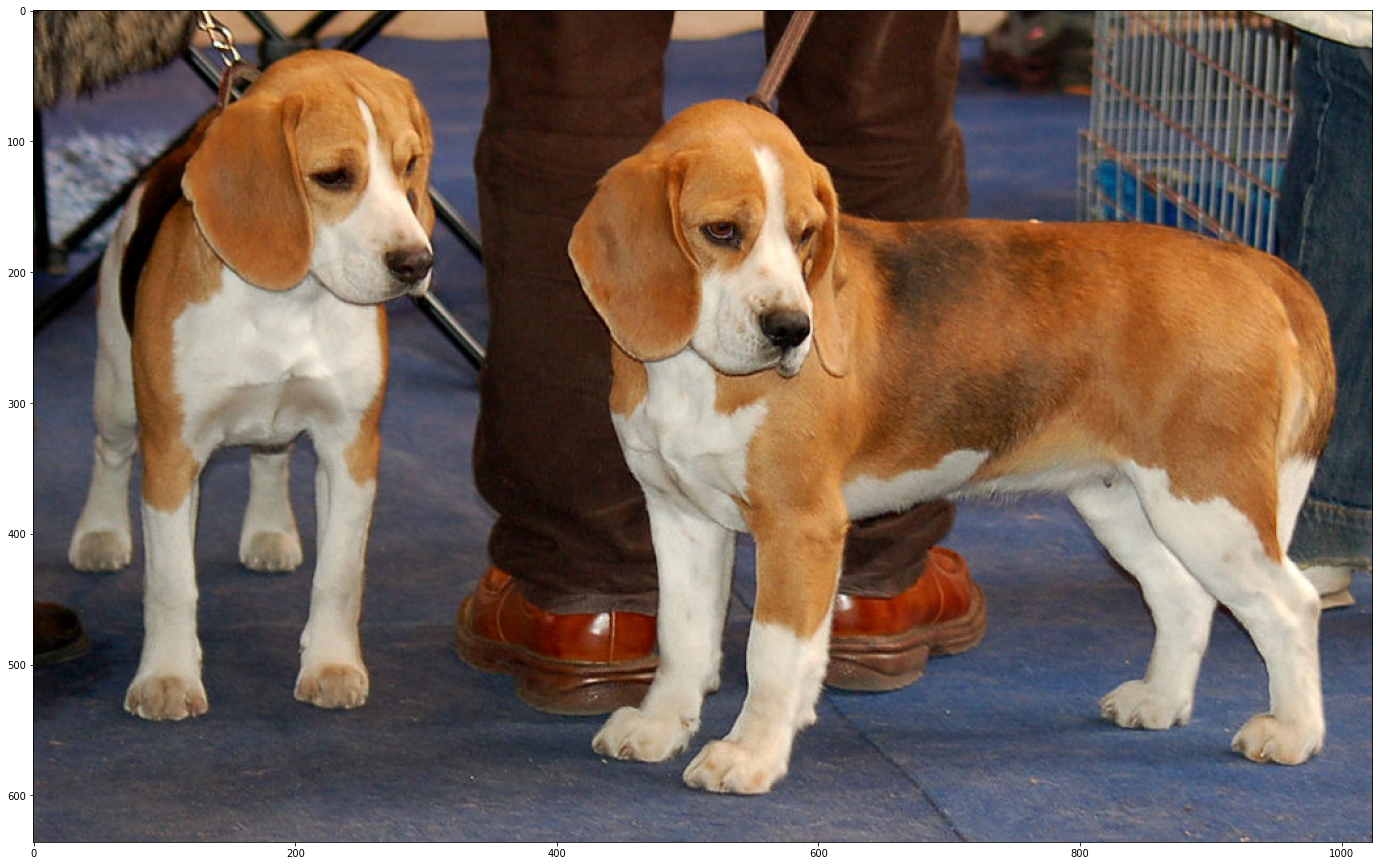

In [14]:
# Choose one and use as key for TEST_IMAGES below: 
# ['Beach', 'Street', 'Dogs','Phones']

image_path = TEST_IMAGES['Dogs']

image_np = load_image_into_numpy_array(image_path)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

You can run inference by simply passing the numpy array of a *single* image to the model. Take note that this model does not support batching. As you've seen in the notebooks in Week 2, this will output a dictionary containing the results. These are described in the `Outputs` section of the [documentation](https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1)

In [15]:
# run inference
results = hub_model(image_np)

# output values are tensors and we only need the numpy() 
# parameter when we visualize the results
result = {key:value.numpy() for key,value in results.items()}

# print the keys
for key in result.keys():
    print(key)

anchors
proposal_boxes_normalized
class_predictions_with_background
num_detections
rpn_objectness_predictions_with_background
detection_classes
mask_predictions
detection_masks
detection_anchor_indices
detection_multiclass_scores
rpn_features_to_crop
rpn_box_predictor_features
image_shape
box_classifier_features
rpn_box_encodings
proposal_boxes
raw_detection_boxes
refined_box_encodings
detection_boxes
raw_detection_scores
detection_scores
num_proposals
final_anchors


## Visualizing the results

You can now plot the results on the original image. First, you need to create the `category_index` dictionary that will contain the class IDs and names. The model was trained on the [COCO2017 dataset](https://cocodataset.org/) and the API package has the labels saved in a different format (i.e. `mscoco_label_map.pbtxt`). You can use the [create_category_index_from_labelmap](https://github.com/tensorflow/models/blob/5ee7a4627edcbbaaeb8a564d690b5f1bc498a0d7/research/object_detection/utils/label_map_util.py#L313) internal utility function to convert this to the required dictionary format.

In [16]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# sample output
print(category_index[1])
print(category_index[2])
print(category_index[4])

{'id': 1, 'name': 'person'}
{'id': 2, 'name': 'bicycle'}
{'id': 4, 'name': 'motorcycle'}


Next, you will preprocess the masks then finally plot the results.

* The result dictionary contains a `detection_masks` key containing segmentation masks for each box. That will be converted first to masks that will overlay to the full image size. 
* You will also select mask pixel values that are above a certain threshold. We picked a value of `0.6` but feel free to modify this and see what results you will get. If you pick something lower, then you'll most likely notice mask pixels that are outside the object.
* As you've seen before, you can use `visualize_boxes_and_labels_on_image_array()` to plot the results on the image. The difference this time is the parameter `instance_masks` and you will pass in the reframed detection boxes to see the segmentation masks on the image.

You can see how all these are handled in the code below.


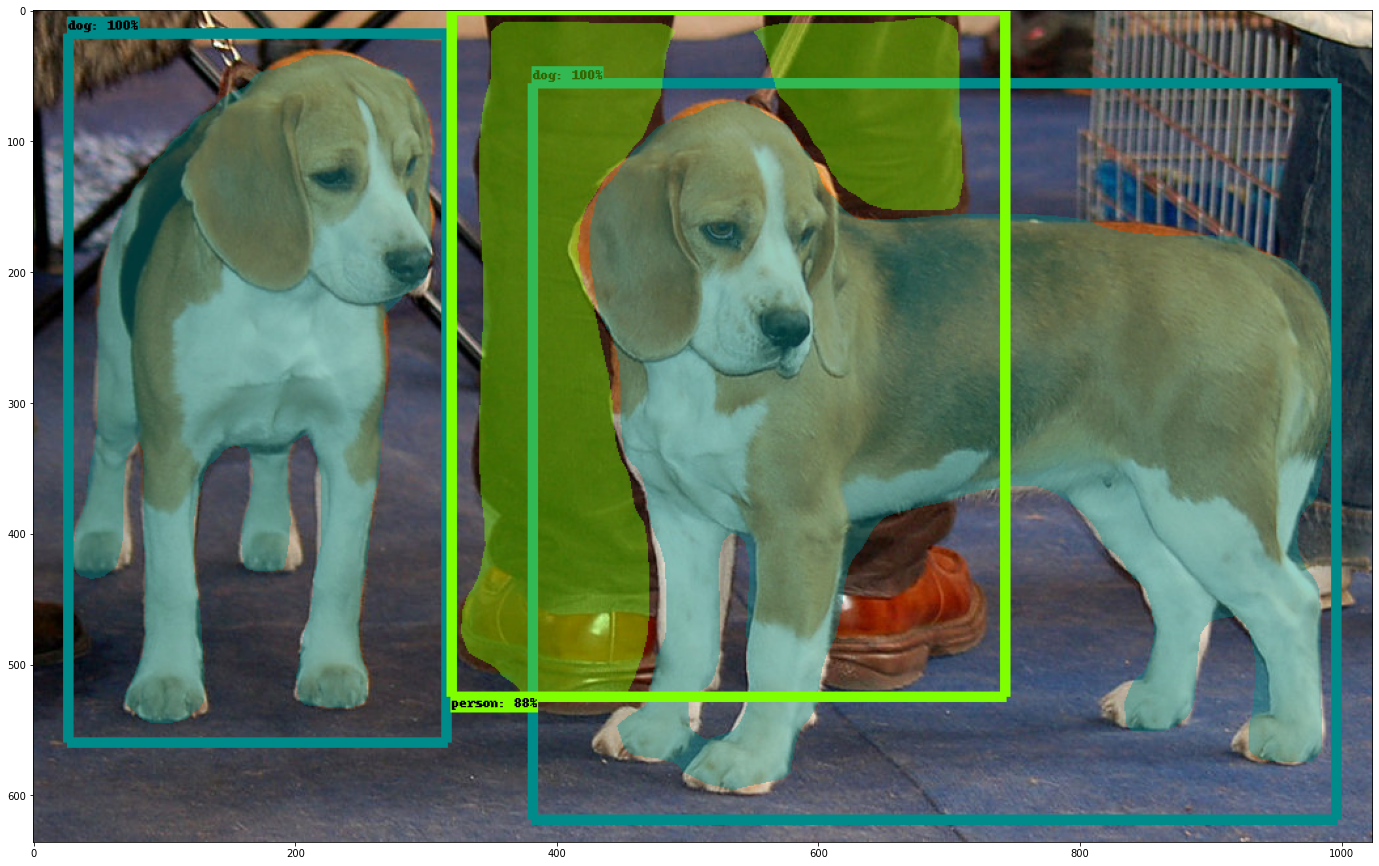

In [17]:
# Handle models with masks:
label_id_offset = 0
image_np_with_mask = image_np.copy()

if 'detection_masks' in result:

    # convert np.arrays to tensors
    detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
    detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

    # reframe the the bounding box mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                detection_masks, detection_boxes,
                image_np.shape[1], image_np.shape[2])

    # filter mask pixel values that are above a specified threshold
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.6, tf.uint8)
    
    # get the numpy array
    result['detection_masks_reframed'] = detection_masks_reframed.numpy()

# overlay labeled boxes and segmentation masks on the image
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_mask[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      min_score_thresh=.70,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=8)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_mask[0])
plt.show()